# Project 2: SOFR Futures and Policy Expectations

**Data**: `project_sofr_futures_20251231.xlsx`, `project_fomc_dates.xlsx`, `project_gsw_yields_20251231.xlsx`, `ref_rates.xlsx`

---

## Project Statement

Use SOFR futures to extract and analyze market expectations of Federal Reserve policy during the 2022–2024 rate cycle. Investigate how accurately futures predicted realized rates, how expectations repriced around FOMC meetings, and how front-end rate surprises transmitted to longer Treasury yields.

---

## Context

### SOFR Futures and Policy Expectations

**SOFR futures** are exchange-traded contracts that settle to the Secured Overnight Financing Rate. Because SOFR closely tracks the Fed Funds target rate, SOFR futures prices encode market expectations about future monetary policy.

The standard price quote is:
$$\text{Price} = 100 - \text{Implied Rate}$$

So a price of 95.25 implies an expected rate of 4.75%.

**3-Month SOFR Futures (SR3)** settle to the compounded average of daily SOFR over the contract quarter. The implied rate reflects market expectations of the average policy rate during that quarter.

### The 2022–2024 Policy Cycle

The Fed's 2022–24 hiking cycle was the most aggressive in decades:

| Date | Event |
|------|-------|
| March 2022 | First hike (25 bp) |
| June 2022 | 75 bp hike—largest since 1994 |
| July 2023 | Peak at 5.25–5.50% |
| March 2023 | SVB collapse—markets suddenly price cuts |
| December 2023 | Powell signals rate cuts ahead |
| September 2024 | First cut (50 bp) |

Markets frequently repriced expectations as inflation data evolved, creating significant futures price volatility and providing rich data for analysis.

### Contract Mechanics

**Ticker convention**: SR3 + month code + year digit
- H = March, M = June, U = September, Z = December
- Example: SR3H4 = March 2024 contract

**Contract specifications**:
- Notional: \$1,000,000
- **DV01: \$25 per basis point** (for one contract)
- Settlement: Compounded SOFR over the contract quarter
- The DV01 is useful for converting rate changes to dollar P\&L

### Data Overview

The validated data spans a rich period for analysis:

| Metric | Value |
|--------|-------|
| **Trading days** | ~750 (2022–2025) |
| **Contracts** | 20 (SR3H2 through SR3Z6) |
| **FOMC meetings** | 24 in 2022–2024 |
| **Key events** | June 2022 (75bp surprise), SVB (Mar 2023), Powell pivot (Dec 2023) |

---

## Resources

### Course Materials
- **Discussion 3.1**: STIR Futures — mechanics, pricing, settlement conventions
- **Discussion 3.2**: Inferring FF Futures — extracting policy expectations from futures
- **Discussion 3.3**: Discount via SOFR Futures — building discount curves, convexity adjustment
- **Appendix 3.X.1**: Convexity Adjustment

### External Reading
- CME Group: [SOFR Futures and Options](https://www.cmegroup.com/markets/interest-rates/stirs/three-month-sofr.html) — contract specifications
- CME FedWatch Tool: [CME FedWatch](https://www.cmegroup.com/markets/interest-rates/cme-fedwatch-tool.html) — methodology for extracting meeting probabilities
- NY Fed: [SOFR](https://www.newyorkfed.org/markets/reference-rates/sofr) — rate calculation methodology
- Federal Reserve: [FOMC Calendars](https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm)

### Data Files

| File | Description | Sheets | Date Range |
|------|-------------|--------|------------|
| `project_sofr_futures_20251231.xlsx` | SOFR 3M futures | `prices`, `implied_rates`, `contract_info` | 2022–2025 |
| `project_fomc_dates.xlsx` | FOMC meeting dates | — | 2015–2025 |
| `project_gsw_yields_20251231.xlsx` | Treasury yields (GSW) | `gsw_yields_key`, `gsw_changes` | 2015–2025 |
| `ref_rates.xlsx` | SOFR, Fed Funds effective | `data` | 2018–2025 |

**Data location**: All files are in the `../data/` directory relative to this notebook.

### Additional Data Sources
- **FRED**: Fed Funds effective rate (DFF), target range (DFEDTARU, DFEDTARL)
- **CME**: Volume and open interest data (optional)

---

## Data Preview

The following code loads the data and creates initial visualizations.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.max_columns', 15)
figsize = (12, 5)

DATA_PATH = '../../data/'

In [ ]:
# Load SOFR futures data
sofr_prices = pd.read_excel(DATA_PATH + 'project_sofr_futures_20251231.xlsx', sheet_name='prices')
sofr_prices['date'] = pd.to_datetime(sofr_prices['date'])
sofr_prices = sofr_prices.set_index('date').sort_index()

sofr_rates = pd.read_excel(DATA_PATH + 'project_sofr_futures_20251231.xlsx', sheet_name='implied_rates')
sofr_rates['date'] = pd.to_datetime(sofr_rates['date'])
sofr_rates = sofr_rates.set_index('date').sort_index()

contract_info = pd.read_excel(DATA_PATH + 'project_sofr_futures_20251231.xlsx', sheet_name='contract_info')
contract_info['expiry_date'] = pd.to_datetime(contract_info['expiry_date'])

print(f"SOFR Futures: {sofr_rates.shape[0]} trading days, {sofr_rates.shape[1]} contracts")
print(f"Date range: {sofr_rates.index.min().date()} to {sofr_rates.index.max().date()}")

# List contracts sorted by expiry
tickers = contract_info.sort_values('expiry_date')['ticker'].tolist()
print(f"\nContracts: {tickers[:5]} ... {tickers[-3:]}")
display(contract_info.head())

SOFR Futures: 1244 trading days, 20 contracts
Date range: 2022-01-02 to 2025-12-30

Contracts: ['SR3H2', 'SR3M2', 'SR3U2', 'SR3Z2', 'SR3H3'] ... ['SR3M6', 'SR3U6', 'SR3Z6']


,ticker,expiry_month,expiry_year,expiry_date
0,SR3H2,3,2022,2022-03-16
1,SR3M2,6,2022,2022-06-15
2,SR3U2,9,2022,2022-09-21
3,SR3Z2,12,2022,2022-12-21
4,SR3H3,3,2023,2023-03-15


In [ ]:
# Load FOMC dates
fomc = pd.read_excel(DATA_PATH + 'project_fomc_dates.xlsx')
fomc['date'] = pd.to_datetime(fomc['date'])

# Filter to relevant period (2022-2024)
fomc_sample = fomc[(fomc['year'] >= 2022) & (fomc['year'] <= 2024)].copy()
print(f"FOMC meetings 2022-2024: {len(fomc_sample)}")
print(f"\nMeetings by year:")
print(fomc_sample.groupby('year').size())
display(fomc_sample.head(10))

FOMC meetings 2022-2024: 24

Meetings by year:
year
2022    8
2023    8
2024    8
dtype: int64


,date,year,month
57,2022-01-26,2022,1
58,2022-03-16,2022,3
59,2022-05-04,2022,5
60,2022-06-15,2022,6
61,2022-07-27,2022,7
62,2022-09-21,2022,9
63,2022-11-02,2022,11
64,2022-12-14,2022,12
65,2023-02-01,2023,2
66,2023-03-22,2023,3


In [ ]:
# Load Treasury yields (GSW)
gsw_yields = pd.read_excel(DATA_PATH + 'project_gsw_yields_20251231.xlsx', sheet_name='gsw_yields_key')
gsw_yields['date'] = pd.to_datetime(gsw_yields['date'])
gsw_yields = gsw_yields.set_index('date').sort_index()

# Filter to relevant period
gsw_yields = gsw_yields['2022':'2024']
print(f"GSW Treasury yields: {gsw_yields.shape[0]} days")
print(f"Maturities: {list(gsw_yields.columns)}")
display(gsw_yields.tail())

GSW Treasury yields: 782 days
Maturities: ['2Y', '5Y', '10Y']


,2Y,5Y,10Y
date,,,
2024-12-25,NaN,NaN,NaN
2024-12-26,4.3167,4.3464,4.6474
2024-12-27,4.3173,4.3635,4.6736
2024-12-30,4.2635,4.3034,4.6215
2024-12-31,4.2545,4.3000,4.6264


In [ ]:
# Load reference rates (SOFR, Fed Funds) - needed for forecast accuracy in Q3
ref_rates = pd.read_excel(DATA_PATH + 'ref_rates.xlsx', sheet_name='data')
ref_rates['date'] = pd.to_datetime(ref_rates['date'])
ref_rates = ref_rates.set_index('date').sort_index()

print(f"Reference rates: {ref_rates.shape[0]} days")
print(f"Columns: {list(ref_rates.columns)}")
ref_rates.tail()

Reference rates: 2714 days
Columns: ['DTB3', 'DFF', 'SOFR']


,DTB3,DFF,SOFR
date,,,
2025-06-02,4.25,4.33,4.35
2025-06-03,4.24,4.33,4.32
2025-06-04,4.25,4.33,4.28
2025-06-05,4.25,4.33,4.29
2025-06-06,NaN,NaN,4.29


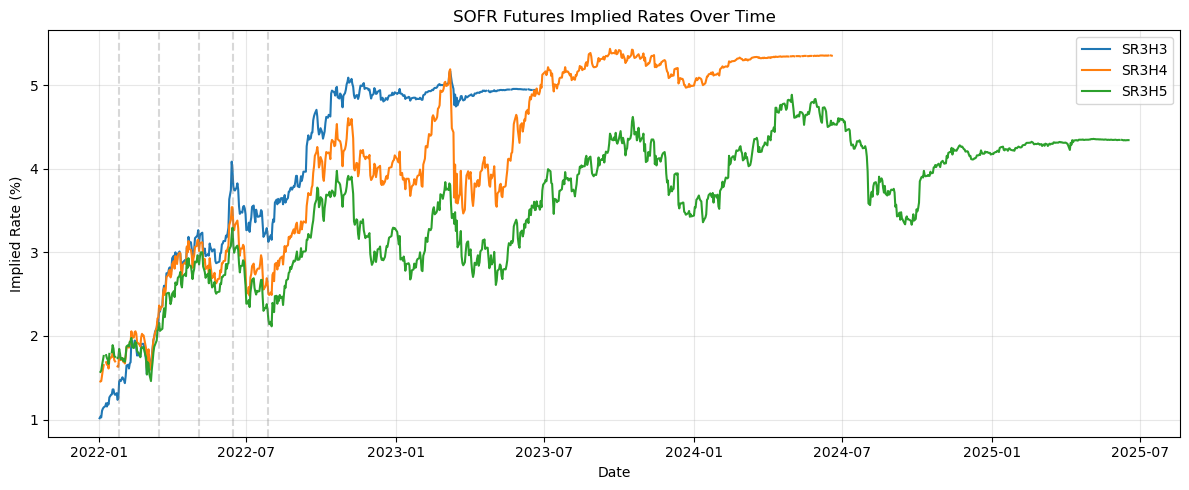

In [ ]:
# Figure 1: Evolution of rate expectations
# Plot implied rate for contracts at different horizons

fig, ax = plt.subplots(figsize=figsize)

# Select a few contracts to show expectations at different horizons
contracts_to_plot = ['SR3H3', 'SR3H4', 'SR3H5']  # March 2023, 2024, 2025

for ticker in contracts_to_plot:
    if ticker in sofr_rates.columns:
        ax.plot(sofr_rates.index, sofr_rates[ticker], label=ticker, linewidth=1.5)

# Mark FOMC dates
for d in fomc_sample['date'][:5]:  # First 5 meetings
    ax.axvline(d, color='gray', alpha=0.3, linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Implied Rate (%)')
ax.set_title('SOFR Futures Implied Rates Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

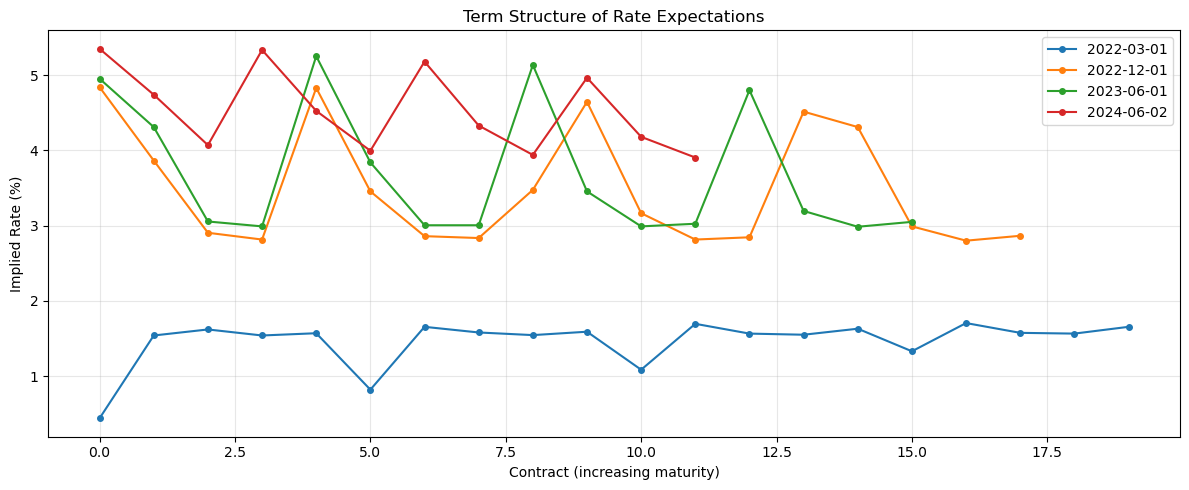

In [ ]:
# Figure 2: Policy expectations curve at different dates
# Shows the term structure of expected rates

snapshot_dates = ['2022-03-01', '2022-12-01', '2023-06-01', '2024-06-01']

fig, ax = plt.subplots(figsize=figsize)

for date_str in snapshot_dates:
    date = pd.Timestamp(date_str)
    # Find nearest trading day
    if date not in sofr_rates.index:
        date = sofr_rates.index[sofr_rates.index.get_indexer([date], method='nearest')[0]]
    
    # Get rates for all contracts on this date
    rates = sofr_rates.loc[date].dropna()
    
    # Convert contract names to numeric for plotting
    x = range(len(rates))
    ax.plot(x, rates.values, 'o-', label=str(date.date()), markersize=4)

ax.set_xlabel('Contract (increasing maturity)')
ax.set_ylabel('Implied Rate (%)')
ax.set_title('Term Structure of Rate Expectations')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Key Formulas

The following formulas are essential for this project. Refer back to **Discussion 3.1** and **3.2** for derivations.

### Implied Rate from Futures Price

$$r^{\text{implied}} = 100 - P$$

where $P$ is the futures price. Note: When the price goes **up**, the implied rate goes **down**.

### FOMC Meeting Probability Extraction

For a month with an FOMC meeting on day $m$ (out of $D$ total days):

$$r^{\text{implied}} = \frac{m}{D} \times r^{\text{before}} + \frac{D-m}{D} \times r^{\text{after}}$$

Solving for the expected post-meeting rate:

$$r^{\text{after}} = \frac{D \times r^{\text{implied}} - m \times r^{\text{before}}}{D - m}$$

### Policy Surprise

$$\text{Surprise} = r^{\text{actual}} - r^{\text{expected}}$$

A positive surprise means the Fed was more hawkish than expected.

### Forecast Error

$$\text{Error}_t^{(h)} = r_{t+h}^{\text{actual}} - r_t^{\text{implied}(h)}$$

where $h$ is the forecast horizon (e.g., 3 months, 6 months).

---

## Questions

Address the following questions in your analysis.

### Question 1: Building the Expectations Curve

**Construct and visualize how rate expectations evolved over the 2022–2024 cycle.**

a) For **four snapshot dates** spanning the cycle, extract implied rates from all available SOFR futures contracts and plot the "expected rate path." Choose dates that capture different phases of the policy cycle.

b) Identify key milestones in expectations:
   - When did markets first price a terminal rate above 5%?
   - When did expectations for rate cuts first appear?
   - Track how the expected terminal rate (maximum implied rate across all contracts) evolved over time.

c) Create a time series of the **terminal rate** (peak of the expectations curve each day). Plot it alongside key events (FOMC dates, SVB collapse).

*Guidance*: The implied rates are already calculated in the data (`implied_rates` sheet). Use the `contract_info` sheet to map contract tickers to expiry dates for proper x-axis labeling.

### Question 2: FOMC Meeting Surprises

**Analyze how futures prices responded to FOMC meetings.**

a) For each FOMC meeting in 2022–2024, calculate:
   - The front-month implied rate the day **before** the meeting
   - The front-month implied rate the day **after** the meeting
   - The 1-day change (surprise component)

b) Classify each meeting as:
   - **Hawkish surprise**: implied rate rose more than 5 bp
   - **Dovish surprise**: implied rate fell more than 5 bp
   - **As expected**: change within ±5 bp

   Create a bar chart showing the surprise for each meeting, color-coded by classification.

c) For the **2–3 meetings with the largest surprises**, show how the full futures curve (all contracts) repriced. Did a hawkish front-end surprise raise or lower expectations for rates 1–2 years ahead?

*Guidance*: Use **trading days**, not calendar days. The "front-month" contract is the one with the nearest expiry date still in the future.

### Question 3: Forecast Accuracy

**Evaluate how well futures predicted realized rates.**

a) For each month in 2022–2024, calculate the forecast error at the **3-month horizon**:
   $$\text{Error}_t^{(3)} = r_{t+3}^{\text{actual}} - r_t^{\text{implied}(3)}$$
   
   Use the implied rate from the front SOFR futures contract and compare to the realized average SOFR during the contract's reference quarter (from `ref_rates.xlsx`).

b) Compute summary statistics:
   - **Mean error (bias)**: Were futures systematically too high or too low?
   - **RMSE**: Root mean squared error
   - **Directional accuracy**: What percentage of the time did futures correctly predict whether rates would rise or fall?

c) Split your sample into two regimes:
   - **Hiking phase** (March 2022 – July 2023)
   - **Plateau/cutting phase** (August 2023 – December 2024)
   
   Compare forecast accuracy across regimes. Create a table showing bias and RMSE for each regime.

d) **Interpret**: If futures have predictable biases, what does this suggest about risk premia or behavioral biases in rate expectations?

*Guidance*: The realized rate for a contract should be the average SOFR during the contract's reference quarter, not just a single day.

### Question 4: Transmission to the Treasury Curve

**Analyze how front-end rate surprises affected longer-term Treasury yields.**

a) For each FOMC meeting, calculate the 1-day change in:
   - The front-month SOFR futures implied rate (your "surprise" from Q2)
   - The 2-year, 5-year, and 10-year Treasury yields (from `gsw_yields_key` sheet)

b) Create scatter plots with front-end surprise on the x-axis and Treasury yield change on the y-axis. Fit a regression line to estimate the **transmission beta**:
   $$\Delta y^{(n)} = \alpha + \beta \cdot \Delta r^{\text{front}} + \varepsilon$$
   
   where $n \in \{2Y, 5Y, 10Y\}$.

c) Report the transmission betas and R² for each maturity. How does transmission differ across maturities?

d) Identify any meetings where the transmission pattern was unusual (e.g., front-end up but long-end down). What might explain these cases?

*Guidance*: The GSW data columns are labeled by maturity in years (e.g., '2', '5', '10').

### Question 5: Event Deep-Dive

**Analyze how expectations repriced around a major market event.**

Choose **one** of the following events:

| Event | Date | Description |
|-------|------|-------------|
| **SVB Collapse** | March 10, 2023 | Banking stress triggers sudden repricing of rate expectations |
| **Powell Pivot** | December 13, 2023 | Fed signals rate cuts ahead |

For your chosen event:

a) Plot the **full SOFR futures curve** (all available contracts) at three points:
   - 1 week before the event
   - Day after the event
   - 1 month after the event

b) Quantify the repricing:
   - How much did the expected **terminal rate** change? (Peak of the curve)
   - How much did **near-term expectations** (average of first 2 contracts) change?
   - Calculate a **persistence ratio**: (1-month shift) / (immediate shift). Values near 1.0 mean the repricing was persistent; values near 0 mean it largely reversed.

c) **Interpret**: What does the pattern of repricing tell you about how markets process new information?

*Guidance*: Focus on telling a clear story with your visualizations. Annotate your plots to highlight the key shifts.

### Question 6: Trading Strategy

**Design and backtest a simple trading strategy on SOFR futures.**

a) Implement a **carry strategy**: maintain a long position in the 2nd contract (roughly 6 months out). When the 2nd contract becomes the front contract, roll to the new 2nd contract.

   Use the contract DV01 of \$25 per basis point to compute daily P\&L:
   $$\text{P\&L}_t = -\Delta r_t \times 100 \times \$25$$

   (Long futures profit when rates fall, i.e., prices rise.)

   Report: cumulative P\&L, Sharpe ratio, maximum drawdown.

b) Analyze **regime-conditional performance**:
   - **Hiking phase** (March 2022 – July 2023)
   - **Plateau/cutting phase** (August 2023 onwards)

   In which regime does the carry strategy perform better? Why does this make economic sense given what you learned in Q3 about forecast biases?

c) **Enhance the strategy** with a signal based on your findings from Q1–Q5. Propose and implement one modification. Examples:
   - Only hold when the curve shape suggests favorable carry (e.g., steep vs inverted)
   - Scale position size based on forecast error patterns from Q3
   - Reduce or exit positions around FOMC meetings based on Q2 surprise analysis

   Backtest your enhanced strategy and compare Sharpe ratio and drawdown to the baseline.

d) **Discuss limitations**: What real-world frictions are missing from this backtest? Consider: transaction costs, bid-ask spreads, margin requirements, and roll timing.

*Guidance*: The goal is not to find an amazing strategy—it's to connect trading logic to your analytical findings. A well-reasoned modification that doesn't improve performance is perfectly acceptable if you explain why.

---

## Your Analysis

*Begin your work below. Add cells as needed.*

In [ ]:
# Your analysis here